In [333]:
# Imports
%load_ext autoreload
%autoreload 2

# ignore warnings for readability
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import torch
import torch.nn as nn

import ili
from ili.dataloaders import NumpyLoader
from ili.inference import InferenceRunner
from ili.validation.metrics import PlotSinglePosterior
from sklearn.model_selection import train_test_split


device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Device:', device)
print("Pytorch version: " + torch.__version__)
print("ROCM HIP version: " + torch.version.hip)
torch.cuda.set_device('cuda:0')

import synthesizer
from synthesizer.parametric import Galaxy
from synthesizer.emission_models import PacmanEmission, TotalEmission, EmissionModel, IntrinsicEmission
from synthesizer.emission_models.attenuation import PowerLaw
from synthesizer.emissions import plot_spectra
from synthesizer.emission_models.dust.emission import Greybody
from synthesizer.grid import Grid
from synthesizer.load_data.load_camels import load_CAMELS_IllustrisTNG
from synthesizer.parametric import SFH, Stars, ZDist

from typing import Dict, Any, List, Tuple, Union, Optional, Type
from abc import ABC, abstractmethod
import copy

from scipy.stats import uniform, loguniform

from astropy.io import ascii
from unyt import unyt_array, unyt_quantity, erg, cm, s, Angstrom, um, Hz, m, nJy, K, Msun, Myr, yr, Unit, kg
from unyt.equivalencies import SpectralEquivalence

from astropy.cosmology import Planck18, Cosmology, z_at_value
from synthesizer.emission_models.attenuation import Inoue14
import astropy.units as u
from matplotlib.ticker import ScalarFormatter, FuncFormatter
from tqdm import tqdm

print(ili.__file__)
print(synthesizer.__file__)

from ltu_ili_testing import generate_emission_models, generate_sfh_basis, generate_metallicity_distribution, sed_grid_generator

from synthesizer import check_openmp
check_openmp()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Device: cuda
Pytorch version: 2.4.1
ROCM HIP version: 6.1.40093-e3dc58bf0
/home/tharvey/work/ltu-ili/ili/__init__.py
/home/tharvey/work/synthesizer/src/synthesizer/__init__.py


False

### Environment Notes

Many CUDA/ROCm packages in pyproject.toml are pinned specifically to compiled versions on my machine so the GPU works.
Had to downgrade numpy <2.0 for harmonic. Unclear if this will cause other issues.

ili is installed as editable.

In [2]:
sed_path = 'Yggdrasil/PopIII.1_fcov_1_SFR_10M_yr_Spectra'

### Load Ygrdrassil models

Loaded 47 SED datasets from file.

SED #1:
  Mass available for star formation (Msolar): 1.00000e+006
  Age (Myr): 1.00000e-002
  Gas mass converted into stars at current age: 1.00000e+003
  Stellar mass (Msolar) at current age: 0.00000e+000
  Wavelength data points: 3283
  Wavelength unit: AA
  Energy unit: erg/s/Hz

  Data points: 3283
  Wavelength range: 91.0033 Å - 90165900.0 Å AA
  Flux range: 0.000e+00 erg/(Hz*s) - 3.617e+26 erg/(Hz*s) erg/s/Hz

SED #2:
  Age (Myr): 1.09900e-001
  Gas mass converted into stars at current age: 1.10000e+004
  Stellar mass (Msolar) at current age: 0.00000e+000
  Wavelength data points: 3283
  Wavelength unit: AA
  Energy unit: erg/s/Hz

  Data points: 3283
  Wavelength range: 91.0033 Å - 90165900.0 Å AA
  Flux range: 0.000e+00 erg/(Hz*s) - 4.106e+27 erg/(Hz*s) erg/s/Hz

SED #3:
  Age (Myr): 2.09900e-001
  Gas mass converted into stars at current age: 2.10000e+004
  Stellar mass (Msolar) at current age: 0.00000e+000
  Wavelength data points: 3283
  W

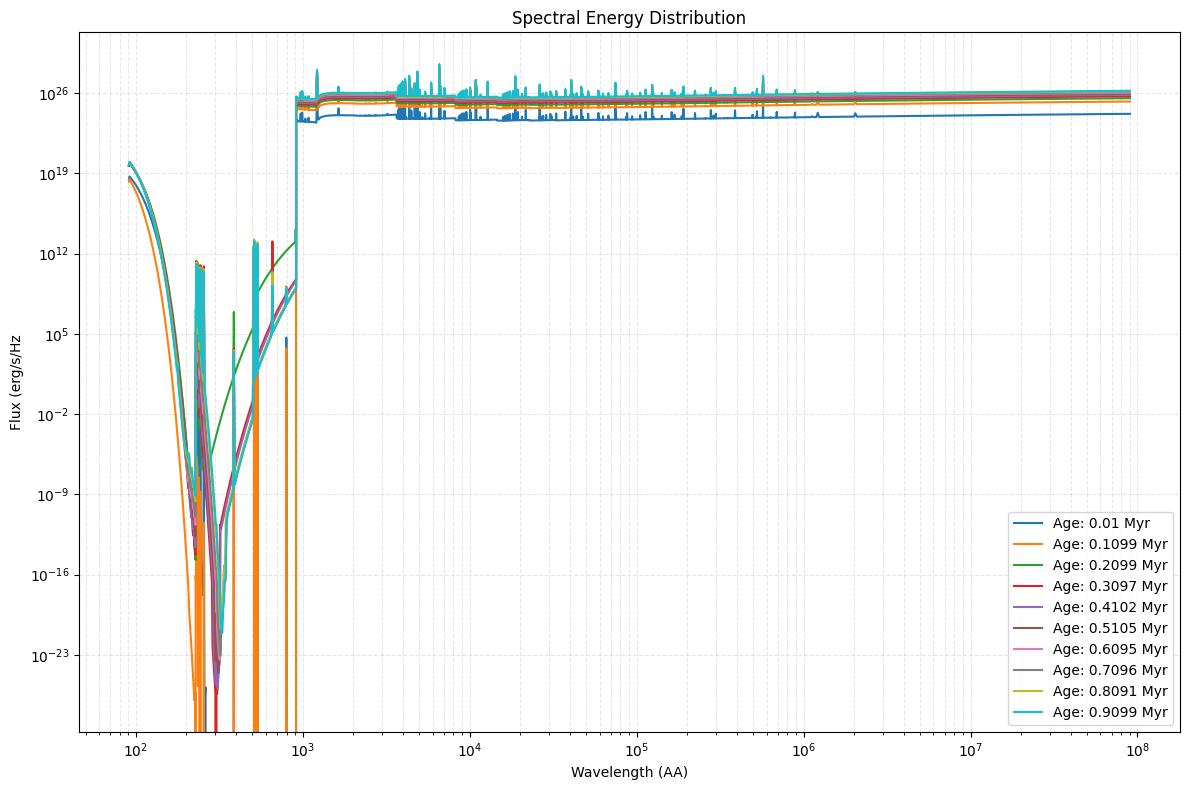

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import re

def load_seds_from_file(filename):
    """
    Load multiple SED datasets from a text file.
    
    Parameters:
    -----------
    filename : str
        Path to the text file containing multiple SED datasets
        
    Returns:
    --------
    list
        List of dictionaries, each containing metadata and wavelength/flux data for one SED
    """
    seds = []
    current_metadata = {}
    current_wavelength = []
    current_flux = []
    
    with open(filename, 'r') as file:
        lines = file.readlines()
        
        in_data_section = False
        
        for i, line in enumerate(lines):
            line = line.strip()
            
            # Skip empty lines
            if not line:
                continue
            
            # Check if this is the start of a new SED section
            if "Age (Myr):" in line and in_data_section:
                # Save the current SED data before starting a new one
                if current_wavelength and current_flux:
                    seds.append({
                        "metadata": current_metadata.copy(),
                        "wavelength": np.array(current_wavelength),
                        "flux": np.array(current_flux)
                    })
                    
                # Reset for the new SED
                current_metadata = {}
                current_wavelength = []
                current_flux = []
                in_data_section = False
            
            # Process data section
            if in_data_section:
                # Handle potential formatting issues in the data
                line = line.replace("'", "").strip()
                parts = re.split(r'\s+', line)
                
                if len(parts) >= 2:
                    try:
                        wl = float(parts[0])
                        fl = float(parts[1])
                        current_wavelength.append(wl)
                        current_flux.append(fl)
                    except ValueError:
                        # Skip lines that can't be parsed as numbers
                        pass
            
            # Parse metadata
            elif "Wavelength (AA)" in line and "Flux" in line:
                in_data_section = True
            elif ":" in line:
                key, value = line.split(":", 1)
                current_metadata[key.strip()] = value.strip()
            elif "Wavelength unit" in line:
                parts = line.split(":", 1) if ":" in line else line.split()
                if len(parts) > 1:
                    current_metadata["Wavelength unit"] = parts[1].strip() if ":" in line else parts[2].strip()
            elif "Energy unit" in line:
                parts = line.split(":", 1) if ":" in line else line.split()
                if len(parts) > 1:
                    current_metadata["Energy unit"] = parts[1].strip() if ":" in line else parts[2].strip()
    
    # Don't forget to add the last SED
    if current_wavelength and current_flux:
        seds.append({
            "metadata": current_metadata,
            "wavelength": np.array(current_wavelength),
            "flux": np.array(current_flux)
        })

    
    for i, sed in enumerate(seds):
        # Convert wavelength and flux to unyt arrays with appropriate units
        sed["wavelength"] = unyt_array(sed["wavelength"], units=Angstrom)
        sed["flux"] = unyt_array(sed["flux"], units=erg / (s * Angstrom))
        # convert to fnu (erg/s*Hz)
        sed["flux"] = (sed["flux"] * sed["wavelength"]**2/ (2.99792458e9  * m/s)).to(erg / (s * Hz))
        sed['metadata']['Energy unit'] = 'erg/s/Hz'

    
    return seds

def load_seds_from_files(filenames):
    """
    Load multiple SED datasets from a list of text files.
    
    Parameters:
    -----------
    filenames : list
        List of paths to text files containing SED datasets
        
    Returns:
    --------
    list
        List of dictionaries, each containing metadata and wavelength/flux data for one SED
    """
    seds = []
    
    for filename in filenames:
        seds.extend(load_seds_from_file(filename))
    
    return seds

def plot_sed(sed_data, ax=None, label=None):
    """
    Plot a single SED dataset.
    
    Parameters:
    -----------
    sed_data : dict
        Dictionary containing wavelength and flux data
    ax : matplotlib.axes.Axes, optional
        Axes to plot on. If None, a new figure is created.
    label : str, optional
        Label for the plot legend
    
    Returns:
    --------
    matplotlib.axes.Axes
        The axes on which the plot was drawn
    """
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 6))
    
    # Create a label if not provided
    if label is None and "Age (Myr)" in sed_data["metadata"]:
        label = f"Age: {float(sed_data['metadata']['Age (Myr)']):.4g} Myr"
    
    ax.loglog(sed_data["wavelength"], sed_data["flux"], label=label)
    
    ax.set_xlabel(f'Wavelength ({sed_data["metadata"].get("Wavelength unit", "AA")})')
    ax.set_ylabel(f'Flux ({sed_data["metadata"].get("Energy unit", "erg")}')
    ax.set_title('Spectral Energy Distribution')
    ax.grid(True, which="both", ls="--", alpha=0.3)
    
    if label:
        ax.legend()
    
    return ax

def plot_multiple_seds(seds_data, max_seds=None):
    """
    Create a plot comparing multiple SEDs.
    
    Parameters:
    -----------
    seds_data : list
        List of SED data dictionaries
    max_seds : int, optional
        Maximum number of SEDs to plot. If None, all SEDs are plotted.
    
    Returns:
    --------
    matplotlib.figure.Figure
        The figure containing the plot
    """
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Limit the number of SEDs to plot if specified
    if max_seds is not None:
        seds_to_plot = seds_data[:max_seds]
    else:
        seds_to_plot = seds_data
    
    for i, sed in enumerate(seds_to_plot):
        age = float(sed["metadata"].get("Age (Myr)", f"SED {i+1}"))
        label = f"Age: {age:.4g} Myr"
        plot_sed(sed, ax=ax, label=label)
    
    plt.tight_layout()
    return fig

def print_sed_summary(sed_data, index=None):
    """
    Print a summary of SED metadata and data statistics.
    
    Parameters:
    -----------
    sed_data : dict
        Dictionary containing SED metadata and data
    index : int, optional
        Index of the SED (for display purposes)
    """
    if index is not None:
        print(f"\nSED #{index+1}:")
    else:
        print("\nSED Summary:")
    
    # Print metadata
    for key, value in sed_data["metadata"].items():
        print(f"  {key}: {value}")
    
    # Print data statistics
    print(f"\n  Data points: {len(sed_data['wavelength'])}")
    print(f"  Wavelength range: {sed_data['wavelength'].min()} - {sed_data['wavelength'].max()} {sed_data['metadata'].get('Wavelength unit', 'AA')}")
    print(f"  Flux range: {sed_data['flux'].min():.3e} - {sed_data['flux'].max():.3e} {sed_data['metadata'].get('Energy unit', 'erg')}")

# Example usage
if __name__ == "__main__":
    # Replace 'your_sed_file.txt' with the path to your file
    seds = load_seds_from_file(sed_path)
    
    print(f"Loaded {len(seds)} SED datasets from file.")
    
    # Print summary of first few SEDs
    max_display = min(3, len(seds))
    for i in range(max_display):
        print_sed_summary(seds[i], index=i)
    
    if len(seds) > max_display:
        print(f"\n...and {len(seds) - max_display} more SED datasets.")
    
    # Plot all SEDs on the same graph (limit to 10 for readability)
    max_plot = min(10, len(seds))
    if max_plot < len(seds):
        print(f"\nPlotting first {max_plot} of {len(seds)} SEDs...")
    
    fig = plot_multiple_seds(seds, max_seds=max_plot)
    plt.show()
    

### Setup Filters

In [3]:
from synthesizer.filters import FilterCollection
from synthesizer.instruments import Instrument

filter_codes = [
    "JWST/NIRCam.F090W",
    "JWST/NIRCam.F115W",
    "JWST/NIRCam.F150W",
    "JWST/NIRCam.F162M",
    "JWST/NIRCam.F182M",
    "JWST/NIRCam.F200W",
    "JWST/NIRCam.F210M",
    "JWST/NIRCam.F250M",
    "JWST/NIRCam.F277W",
    "JWST/NIRCam.F300M",
    "JWST/NIRCam.F335M",
    "JWST/NIRCam.F356W",
    "JWST/NIRCam.F410M",
    "JWST/NIRCam.F444W",
]

filterset = FilterCollection(filter_codes)



tophats = {
    "top_hat1": {"lam_eff": 15000 * Angstrom, "lam_fwhm": 1000 * Angstrom},
}
top_hat_filters = FilterCollection(tophat_dict=tophats)

instrument = Instrument('JWST', filters=filterset)


Calculated wavelength array: 
min = 7.74e+03 Angstrom
max = 5.11e+04 Angstrom
FilterCollection.lam.size = 5399
Calculated wavelength array: 
min = 1.45e+04 Angstrom
max = 1.55e+04 Angstrom
FilterCollection.lam.size = 353


### Compute photometry at redshift, supress Lyman alpha, apply Inoue IGM.

### Setup feature array. Split into training and test sets.

In [6]:
# do we even need to give muv? Or is shape enough?

# Can simply give normalized photometry. 
# If we give muv it will be in log10(nJy) units. 
# Giving normalized photometry allows us to pass in negative photometry better


features = filter_codes + \
            ["JWST/NIRCam.F115W-JWST/NIRCam.F150W", "JWST/NIRCam.F150W-JWST/NIRCam.F277W", "JWST/NIRCam.F277W-JWST/NIRCam.F444W"] + \
            ['muv', 'z']


In [ ]:
def compute_photometry_from_sed(sed_data, filterset, redshift, supress_lya=False, plot=False):
    
    if plot:
        fig, ax = plt.subplots(figsize=(10, 6), dpi=200, facecolor='w', edgecolor='k')

    norm_arr = np.full(len(sed_data), np.nan)
    phot_data_arr = np.full((len(sed_data), len(filterset)), np.nan)

    for pos, sed_i in enumerate(sed_data):
        if supress_lya:
            # Find pixel closest to 1216 and set to next pixel
            index = np.argmin(np.abs(sed_i['wavelength'] - 1216 * Angstrom))
            sed_i['flux'][index] = sed_i['flux'][index + 1]
           
        sed = Sed(lam = sed_i['wavelength'], lnu = sed_i['flux'])
        sed.get_fnu(cosmo=cosmo, z = redshift, igm=Inoue14)
        phot = sed.get_photo_fnu(filters=filterset)

        muv = sed.get_lnu_at_lam(15000 * Angstrom)
        # muv is rest-frame luminosity at 15000 Angstrom. Apply cosmological dimming
        # to get apparent magnitude

        muv = (muv * (1 + redshift)**2 / (4 * np.pi * (cosmo.luminosity_distance(redshift).to(u.m).value *m)**2)).to(nJy)

        phot_data = phot.photo_fnu

        norm_arr[pos] = np.log10(muv.value)

        phot_data_arr[pos] = phot_data.value

        if plot:
            wav = phot.filters.pivot_lams
            ax.plot(wav, phot_data/muv, label=f"z={redshift:.2f}")
            ax.set_title(f"SED Photometry (z={redshift:.2f})")
            ax.set_xlabel("Wavelength (Angstrom)")
            ax.set_ylabel("Photometry (normalized to 15000 Angstrom)")
        
    return phot_data_arr, norm_arr


def generate_feature_array(feature_names, seds, redshifts, filterset, supress_lya=False):
    
    feature_array = np.full((len(seds)*len(redshifts), len(feature_names)), np.nan)

    sum_indexes = []
    opp_types = []

    for feature_name in feature_names:
        if '-' in feature_name:
            filters = feature_name.split('-')
            sum_indexes.append([filter_codes.index(filters[0]), filter_codes.index(filters[1])])
            opp_types.append(np.subtract)
        elif '+' in feature_name:
            filters = feature_name.split('+')
            sum_indexes.append([filter_codes.index(filters[0]), filter_codes.index(filters[1])])
            opp_types.append(np.add)
        else:
            pass
            
    for i, redshift in enumerate(redshifts):
        for j, sed in enumerate(seds):
            phot_data_arr, norm_arr = compute_photometry_from_sed([sed], filterset, redshift, supress_lya=supress_lya)
            colors = []
            for k, sum_index in enumerate(sum_indexes):
                colors.append(opp_types[k](phot_data_arr[0][sum_index[0]], phot_data_arr[0][sum_index[1]]))
                
            feature_array[i * len(seds) + j] = np.concatenate((phot_data_arr[0], colors, [norm_arr[0], redshift]))

    return feature_array

redshifts = np.arange(6, 15, 0.1)

feature_array = generate_feature_array(features, seds, redshifts, filterset, supress_lya=True)

### Split into test and train. 

In [8]:
# Split into train/test and build loaders
test_split = 0.1
n_samples = len(feature_array)

# Model 1
mask1 = np.random.rand(n_samples) > test_split
x1_train, x1_test = feature_array[mask1], feature_array[~mask1]
theta1_train, theta1_test = theta1[mask1], theta1[~mask1]


# Build loaders
loader1_train = NumpyLoader(x1_train, theta1_train)
loader1_test = NumpyLoader(x1_test, theta1_test)


NameError: name 'theta1' is not defined

### Setup NDE Function

In [ ]:
# Training scripts to train NPE/NLE with LtU-ILI
def train_nde(loader, prior_mu, engine='NLE'):
    # define a prior
    prior = ili.utils.IndependentNormal(
        loc=prior_mu,
        scale=1*np.ones(Ndim),
        device=device
    )
    # instantiate your neural networks to be used as an ensemble
    nets = [
        ili.utils.load_nde_sbi(
            engine=engine, model='mdn', hidden_features=50, num_components=4),
    ]
    # define training arguments
    train_args = {
        'training_batch_size': 64,
        'learning_rate': 5e-4
    }
    # initialize the trainer
    runner = InferenceRunner.load(
        backend='sbi',
        engine=engine,
        prior=prior,
        nets=nets,
        device=device,
        train_args=train_args,
    )
    # train the model
    posterior_ensemble, summaries = runner(loader=loader)
    return posterior_ensemble, summaries

### Train NLE

In [ ]:
# Train Neural Likelihood Estimation
nle1, summ_nle1 = train_nde(loader1_train, mu1, 'NLE')
nle2, summ_nle2 = train_nde(loader2_train, mu2, 'NLE')

# Train Neural Posterior Estimation
npe1, summ_npe1 = train_nde(loader1_train, mu1, 'NPE')
npe2, summ_npe2 = train_nde(loader2_train, mu2, 'NPE')

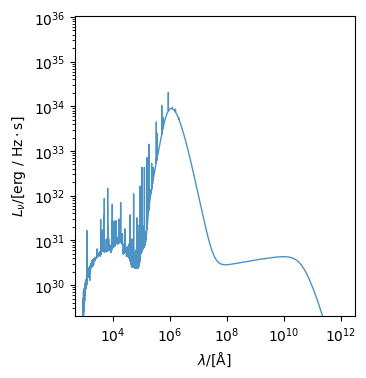

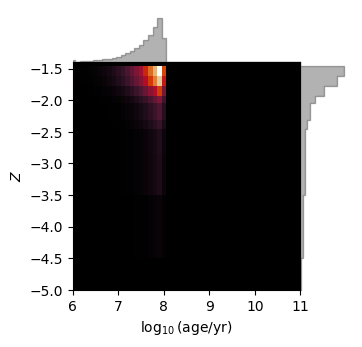

(<Figure size 350x350 with 3 Axes>,
 <Axes: xlabel='$\\log_{10}(\\mathrm{age}/\\mathrm{yr})$', ylabel='$Z$'>)

In [17]:
tau_v = 0.5
# dust curve slope
alpha = -1.0
dust_curve = PowerLaw(slope=alpha)
dust_emission_model = Greybody(30 * K, 1.2)

stellar_mass = 10**11 * Msun
sfh = SFH.Constant(max_age=100 * Myr)
metal_dist = ZDist.Normal(mean=0.01, sigma=0.05)

# Get the 2D star formation and metal enrichment history for the
# given SPS grid. This is (age, Z).
stars = Stars(
    grid.log10age,
    grid.metallicity,
    sf_hist=sfh,
    metal_dist=metal_dist,
    initial_mass=stellar_mass,
)



# Get the model
pacman = PacmanEmission(
    grid=grid,
    tau_v=tau_v,
    dust_curve=dust_curve,
    dust_emission=dust_emission_model,
)

spectra = stars.get_spectra(pacman)

spectra.plot_spectra()

stars.plot_sfzh()

What is a sensible formulation of an alternative model?

Could generalize over a basic grid derived model. E.g. range of metallicities - from supersolar to subsolar, range of SFH ages, range of dust attenuation. Fixed dust law. Fixed or varying ionization parameter? Don't really care about normalization so mass doesn't matter. 

[1.0000e+07 6.3250e+08 1.2550e+09 1.8775e+09 2.5000e+09] [1.000e+07 2.575e+08 5.050e+08 7.525e+08 1.000e+09]
time_limits (-53950000.0, 1132950000.0)
z_ticks [-5.39500e+07  2.42775e+08  5.39500e+08  8.36225e+08  1.13295e+09]
age_at_z [1.37868853e+10 1.12528766e+10 9.33665701e+09 7.86526304e+09
 6.71828957e+09 5.81062935e+09 5.08171952e+09 4.48814829e+09
 3.99849304e+09 3.58974036e+09 3.24481746e+09 2.95089023e+09
 2.69818412e+09 2.47916054e+09 2.28793550e+09 2.11986457e+09
 1.97124303e+09 1.83908663e+09 1.72096951e+09 1.61490289e+09
 1.51924344e+09 1.43262322e+09 1.35389575e+09 1.28209396e+09
 1.21639725e+09 1.15610540e+09 1.10061776e+09 1.04941656e+09
 1.00205337e+09 9.58138190e+08 9.17330358e+08 8.79331204e+08
 8.43877891e+08 8.10738315e+08 7.79706831e+08 7.50600670e+08
 7.23256906e+08 6.97529896e+08 6.73289086e+08 6.50417154e+08
 6.28808408e+08 6.08367406e+08 5.89007772e+08 5.70651165e+08
 5.53226386e+08 5.36668596e+08 5.20918641e+08 5.05922450e+08
 4.91630515e+08 4.77997428e+08 4.64

UnitConversionError: Can only apply 'less' function to dimensionless quantities when other argument is not a quantity (unless the latter is all zero/infinity/nan).

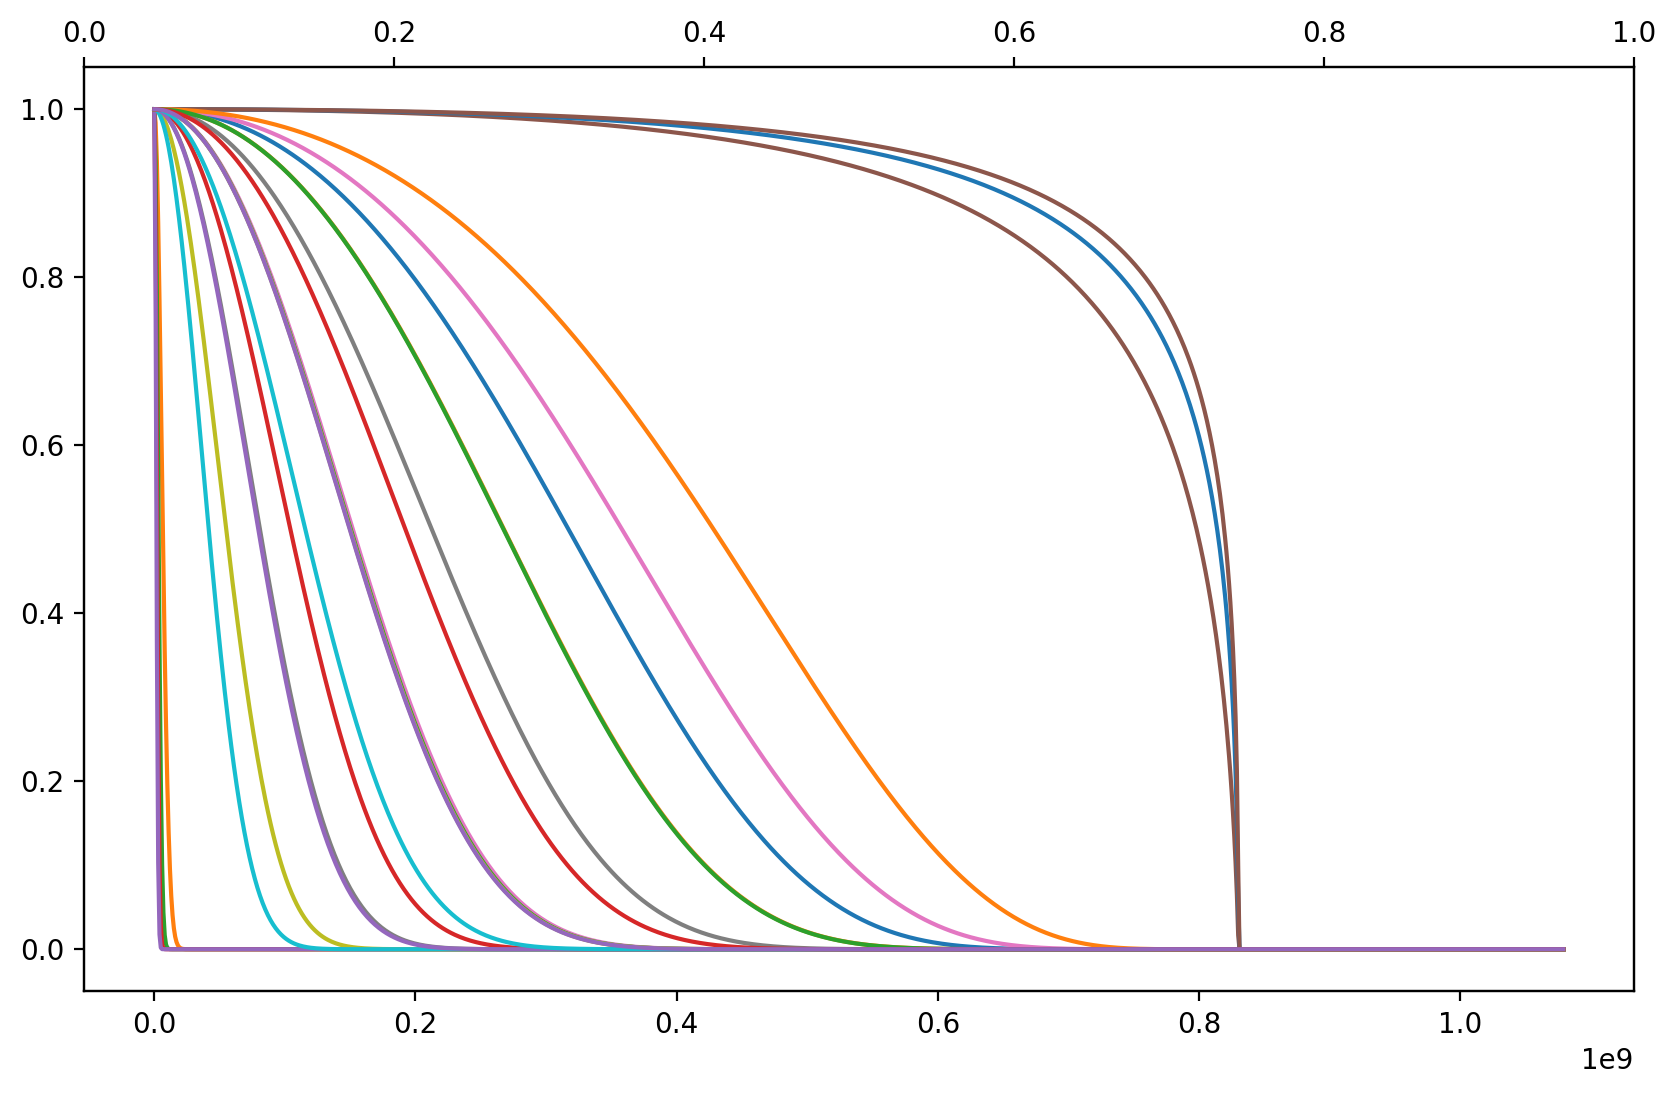

In [ ]:
from scipy.optimize import fsolve
def lognorm_equations(p, consts):
    """ Equations for finding the tau and T0 for a lognormal SFH given
    some tmax and FWHM. Needed to transform variables. """

    tau_solve, T0_solve = p

    xmax, h = consts

    tau = np.exp(T0_solve - tau_solve**2) - xmax
    t0 = xmax*(np.exp(0.5*np.sqrt(8*np.log(2)*tau_solve**2))
               - np.exp(-0.5*np.sqrt(8*np.log(2)*tau_solve**2))) - h

    return (tau, t0)


tmaxes = np.linspace(10, 2500, 5) * Myr 
tmaxes = tmaxes.to(yr).to_value()

FWHMs = np.linspace(10, 1000, 5) * Myr
FWHMs = FWHMs.to(yr).to_value()

print(tmaxes, FWHMs)


# Create a grid of tmax and FWHM values

tmax_grid, FWHM_grid = np.meshgrid(tmaxes, FWHMs)
# Flatten the grid for easier processing
tmax_flat = tmax_grid.flatten()
FWHM_flat = FWHM_grid.flatten() 

# Create a list to store the results
results = []
# Loop through the grid and calculate tau and T0 for each combination


fig, ax = plt.subplots(figsize=(10, 6), dpi=200, facecolor='w', edgecolor='k')


for tmax, fwhm in zip(tmax_flat, FWHM_flat):
    # Define the constants for the equations
    consts = (tmax, fwhm)
    
    # Use fsolve to find the roots of the equations
    
    tau_guess = fwhm/(2*tmax*np.sqrt(2*np.log(2)))
    t0_guess = np.log(tmax) + fwhm**2/(8*np.log(2)*tmax**2)

    tau, t0 = fsolve(lognorm_equations, (tau_guess, t0_guess),
                        args=([tmax, fwhm]))
    
    t0 = t0 * yr


    sfh = SFH.LogNormal(tau=tau, peak_age=t0, max_age=max_age, min_age=-1000 * Myr)
    age, sfr = sfh.calculate_sfh(t_range=(0, 1.3*max_age.to(yr)), dt=1e6*yr)                                       
    sfr = sfr / sfr.max()
    ax.plot(age, sfr, label=f"tau={tau:.2f}, peak_age={peak_age:.2f}")
    

    # add secondary axis showing redshift





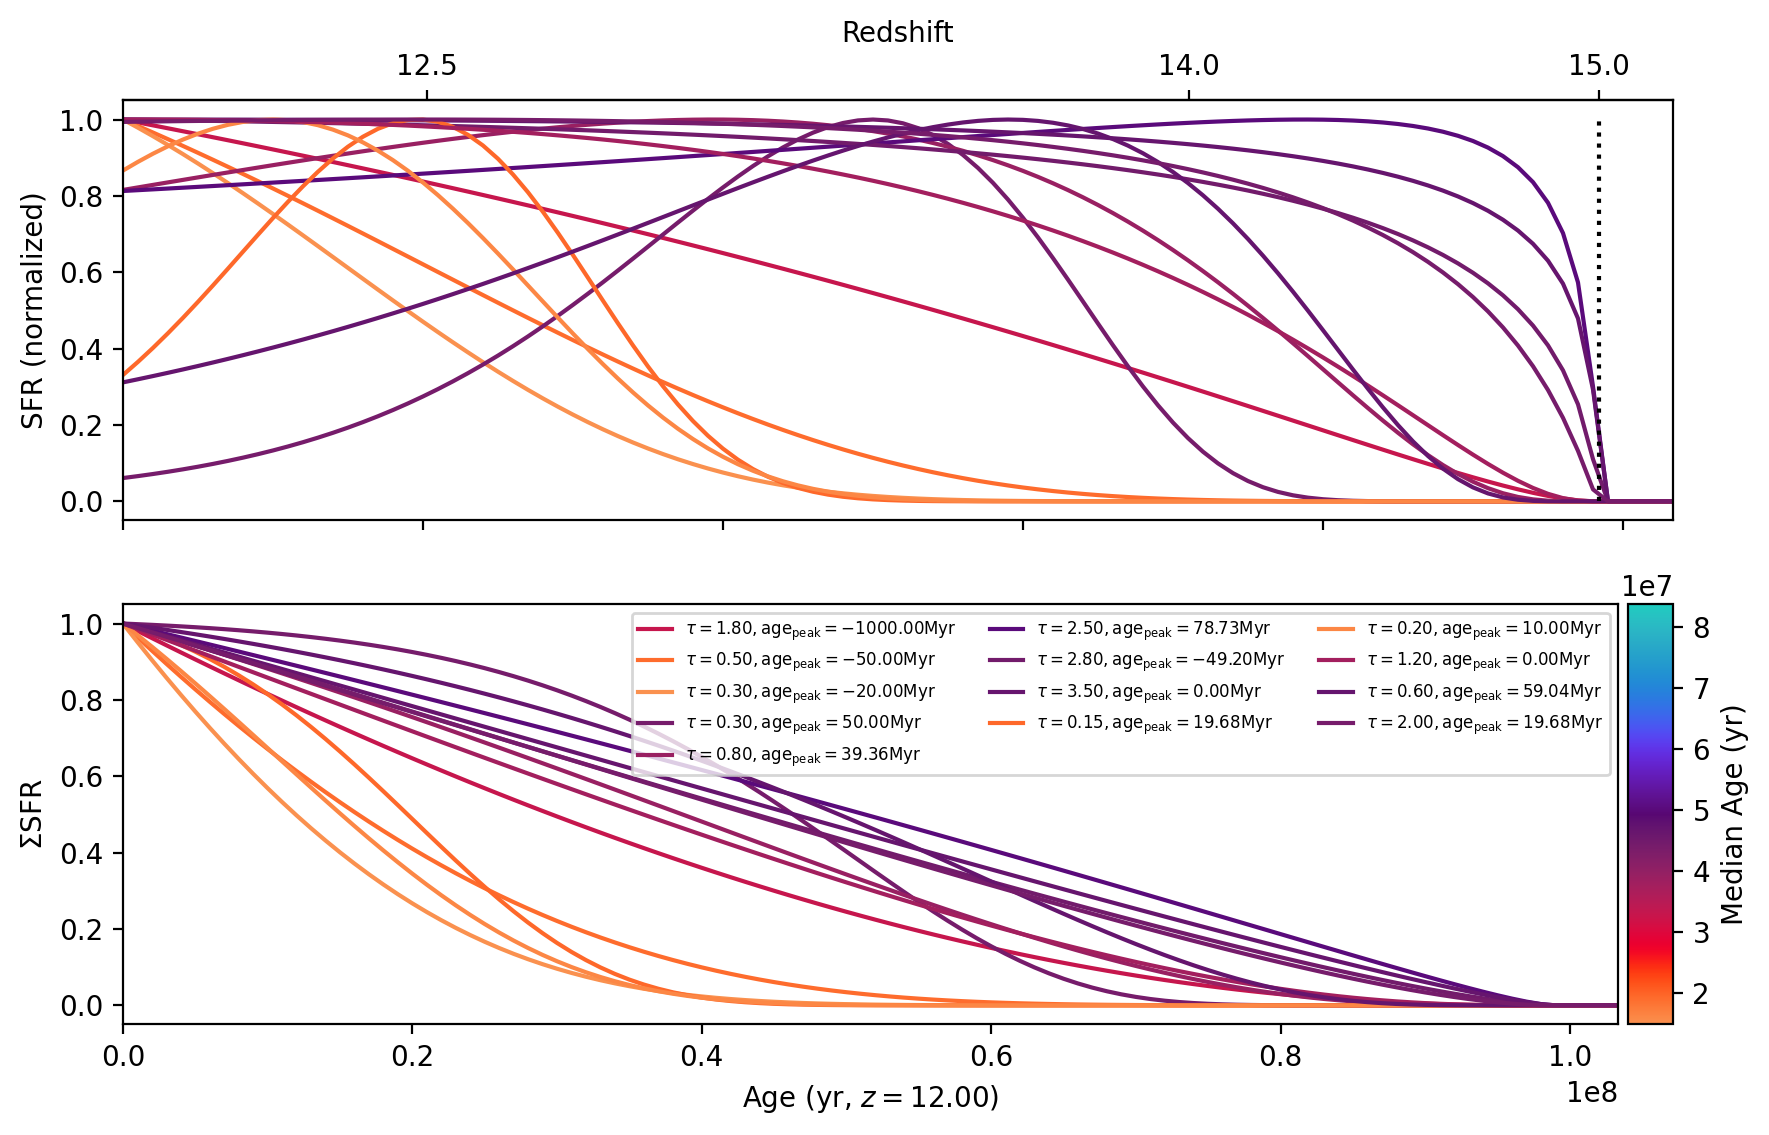

In [ ]:
redshift = 12

from cmasher import take_cmap_colors
import cmasher
from matplotlib.colors import Normalize
import matplotlib.cm as cm
from mpl_toolkits.axes_grid1 import make_axes_locatable



max_redshift = 15

max_age = (Planck18.age(redshift) - Planck18.age(max_redshift)).to(u.Myr).value * Myr

taus = np.linspace(0, 2.0, 10)
peak_ages = np.linspace(-100*Myr, max_age, 5) 

cmap = 'cmr.guppy'
cmap = plt.get_cmap(cmap)



norm = Normalize(vmin=0.15*max_age.to(yr).value, vmax=0.85*max_age.to(yr).value)

# Define parameter grid
taus = np.array([0.1, 0.2, 0.5, 1.0, 1.5, 2.5])  # Width parameter

# For peak ages, using fractional values of max_age helps with interpretation
peak_age_fractions = np.array([ -0.2, -0.05, 0.1, 0.4, 0.7, 0.9])
peak_ages = peak_age_fractions * max_age

# Create the parameter grid
tau_grid, peak_age_grid = np.meshgrid(taus, peak_ages)

# broadcast the two arrays to get every possible combination

tau_array, peak_age_array = np.meshgrid(taus, peak_ages)
tau_values = tau_array.flatten()
peak_age_values = peak_age_array.flatten()



# Define tau values and corresponding peak_age values in terms of max_age

tau_peaks = np.array([                    
    (1.8, -1000),                                 # gradually rising
    (0.5, -50),                                   # moderately rising
    (0.3, -20),                                   # steeply rising
    (0.3, 50 ),                                   # sharp peak with rapid decline
    (0.8, 0.4 * max_age.to(Myr).value),           # moderate peak with steady decline
    (2.5, 0.8 * max_age.to(Myr).value),           # early peak with very slow decline
    (2.8, -0.5 * max_age.to(Myr).value),          # nearly flat, slight increase toward present
    (3.5, 0 ),                                    # extremely broad, essentially constant
    (0.15, 0.2 * max_age.to(Myr).value),          # sharp burst in early universe
    (0.2, 10),                                    # recent sharp burst
    (1.2, 0),                                     # presently at peak, will decline
    (0.6, 0.6 * max_age.to(Myr).value),           # intermediate-age burst
    (2.0, 0.2 * max_age.to(Myr).value)            # broad peak, moderate decline
])

tau_values = tau_peaks[:, 0]
peak_age_values = tau_peaks[:, 1] * Myr



#tau_values = [0.03, 0.3, 0.6, 1.5]
#peak_age_values = [100, 100, 100, 100] * Myr


#tau_values = tau_values[2:5]
#peak_age_values = peak_age_values[2:5]

def plot_lognorm_sfh(tau_values, peak_age_values):

    tau_values = np.atleast_1d(tau_values)
    peak_age_values = np.atleast_1d(peak_age_values)


    fig, axs = plt.subplots(2, 1, figsize=(10, 6), dpi=200, facecolor='w', edgecolor='k', sharex=True)
    ax = axs[0]
    for i in range(len(tau_values)):
        tau = tau_values[i]
        peak_age = peak_age_values[i]
        sfh = SFH.LogNormal(tau=tau, peak_age=peak_age, max_age=max_age, min_age=0*Myr)
        med_age = sfh.calculate_mean_age(dt=1e5)
        age, sfr = sfh.calculate_sfh(t_range=(0, 1.1*max_age.to(yr)), dt=1e6)                                       
        sfr = sfr / sfr.max()
        ax.plot(age, sfr, label=f"tau={tau:.2f}, peak_age={peak_age:.2f}", color=cmap(norm(med_age)))
        # plot cumulative on axs[1]

        mass_formed = np.cumsum(sfr[::-1])[::-1]/np.sum(sfr)

        axs[1].plot(age, mass_formed, color=cmap(norm(med_age)), label=rf'$\tau = {tau:.2f}, \rm age_{{peak}} = {peak_age:.2f}$')
        

    axs[1].set_xlabel(f"Age (yr, $z={redshift:.2f}$)")
    ax.set_ylabel("SFR (normalized)")
    ax.set_xlim(0, 1.05*max_age.to(yr))

    # import make_axes_divisble

    cax = make_axes_locatable(axs[1]).append_axes("right", size="3%", pad=0.05)


    fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), ax=axs[1], cax=cax)
    cax.set_ylabel('Median Age (yr)')

    # Get current xticks, calculate what they would be in age of universe using the cosmology, then convert that to redshift. Add redshift ticks

    cosmo = Planck18

    def time_convert(lookback_time):
        lookback_time = lookback_time * u.yr
        return z_at_value(
            cosmo.lookback_time,
            cosmo.lookback_time(redshift) + lookback_time,
        ).value

    def z_convert(z):
        if type(z) in [list, np.ndarray] and len(z) == 0:
            return np.array([])
        
        return (
            cosmo.lookback_time(z) - cosmo.lookback_time(redshift)
        ).to(u.yr).value

    axs[1].legend(loc='upper right', fontsize=6, ncols=3)

    secax = ax.secondary_xaxis("top", functions=(time_convert, z_convert))
    secax.set_xlabel(f"Redshift")

    # Put a vertical line at maximum redshift

    secax.set_xticks([6, 7, 8, 10, 12, 12.5, 14, 15, 20])

    ax.vlines(max_age.to(yr), 0, 1, color='black', linestyles='dotted')

    axs[1].set_ylabel(r'$\Sigma \rm SFR$')

plot_lognorm_sfh(tau_values, peak_age_values)


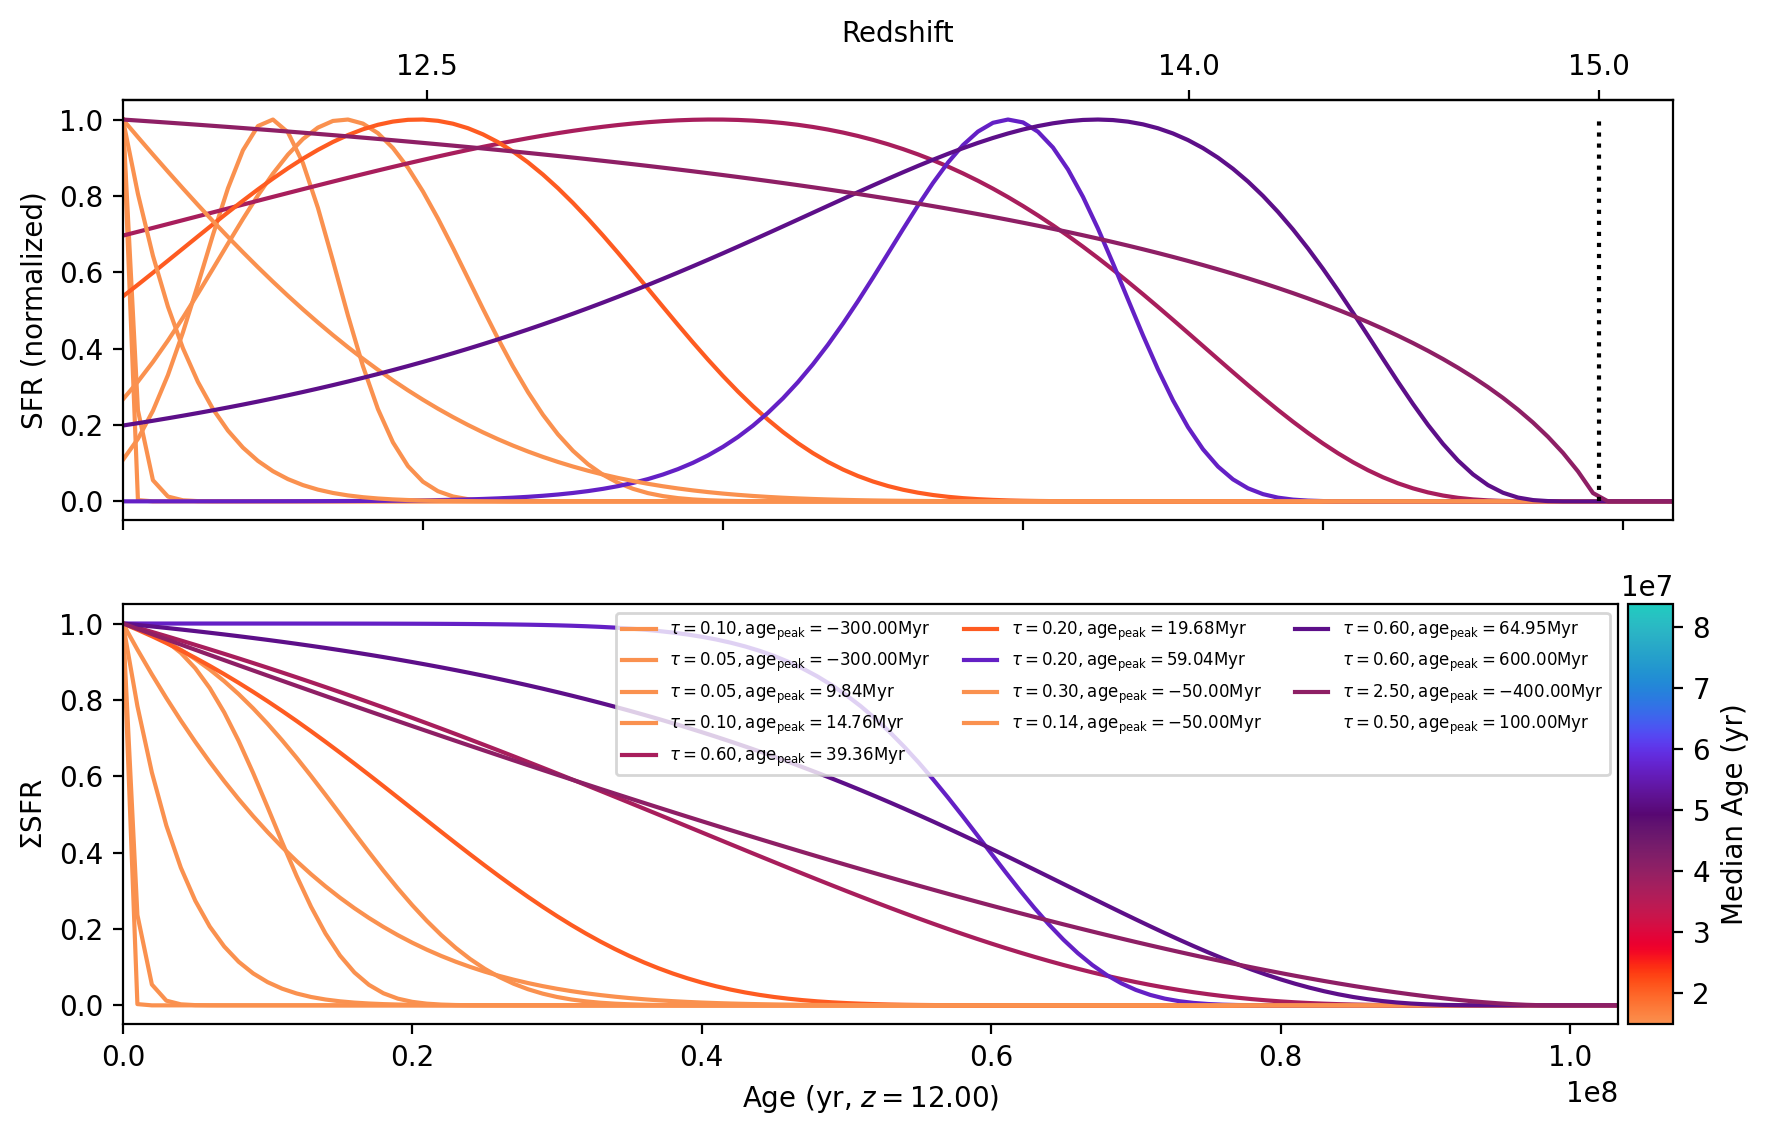

In [ ]:
tau_peak_keep = np.array([    
        (0.1, -300),  # Recent burst, rising SFH
        (0.05, -300), # Very recent burst           
        (0.05,  lambda max_age: 0.1*max_age), # Very recent burst       
        (0.1,  lambda max_age: 0.15*max_age), # older burst, declining SFH
        (0.6,  lambda max_age:0.4*max_age), # Fairly flat, slight decline 
        (0.2,  lambda max_age: 0.2*max_age), # Fairly flat, slight decline 
        (0.2,  lambda max_age:0.6*max_age), # Quiescent 
        (0.3, -50), # slowly rising
        (0.14,  -50), # medium rising
        (0.6,  lambda max_age: 0.66 * max_age),
        (0.6,  lambda max_age: 0.8 * max_age),# early burst, now quiescent
        (2.5,  lambda max_age: -0.5*max_age), # early and constant
        (0.5,  100), # early and constant

])

tau_values = tau_peak_keep[:, 0]
peak_age_values = tau_peak_keep[:, 1] * Myr


plot_lognorm_sfh(tau_values, peak_age_values)

In [331]:
# General
grid = Grid('bpass-2.2.1-bin_chabrier03-0.1,300.0_cloudy-c23.01-sps.hdf5',
            grid_dir='/home/tharvey/work/synthesizer_grids/')

max_redshift = 20 # gives maximum age of SFH at a given redshift
redshift = np.arange(6, 15, 1)   #={'prior': uniform, 'min': 5, 'max': 15, 'size': 10}
cosmo = Planck18 # cosmology to use for age calculations

# Metallicity 
Z_dist = ZDist.DeltaConstant
min_logZ = -3 # minimum log10 metallicity
max_logZ = 0.3 # maximum log10 metallicity
N_Z = 5 # number of metallicity distributions to generate

# SFH parameters
min_mass = 6 # minimum log10 stellar mass
max_mass = 11 # maximum log10 stellar mass
mass_step = 1.0 # step in stellar mass
sfh_type = SFH.LogNormal

sfh_param_names = ['tau', 'peak_age']
tau_peak = np.array([    
        (0.1, -300),  # Recent burst, rising SFH
        (0.05, -300), # Very recent burst           
        (0.05,  lambda max_age: 0.1*max_age), # Very recent burst       
        (0.1,  lambda max_age: 0.15*max_age), # older burst, declining SFH
        (0.6,  lambda max_age:0.4*max_age), # Fairly flat, slight decline 
        (0.2,  lambda max_age: 0.2*max_age), # Fairly flat, slight decline 
        (0.2,  lambda max_age:0.6*max_age), # Quiescent 
        (0.3, -50), # slowly rising
        (0.14,  -50), # medium rising
        (0.6,  lambda max_age: 0.66 * max_age),
        (0.6,  lambda max_age: 0.8 * max_age),# early burst, now quiescent
        (2.5,  lambda max_age: -0.5*max_age), # early and constant
        (0.5,  100), # early and constant

])
sfh_param_units = [None, Myr]


sfh_models, redshifts = generate_sfh_basis(
    sfh_type=sfh_type,
    sfh_param_names=sfh_param_names,
    sfh_param_arrays=tau_peak,
    redshifts=redshift,
    max_redshift=max_redshift,
    cosmo=cosmo,
    sfh_param_units=sfh_param_units,
)

# Emission model

emission_model = TotalEmission
dust_curve = PowerLaw(slope=-1)
fesc = 0
fesc_ly_alpha = 0
dust_emission_model = None


emission_models = generate_emission_models(
    emission_model=emission_model,
     grid=grid,
    varying_params={
        'tau_v': {
            'prior': loguniform, 
            'a': 1e-3, 
            'b': 2, 
            'size': 10, 
            'units': None,
            'name': 'tau_v'
        },
    },
    fixed_params={
        'dust_curve': dust_curve,
        'fesc': fesc,
        'fesc_ly_alpha': fesc_ly_alpha,
        'dust_emission_model': dust_emission_model,
    }
)

Z_dists = [Z_dist(log10metallicity=i) for i in np.linspace(min_logZ, max_logZ, N_Z)]


# Pop III parameters
sfh_array = np.array([(0, 10), (0, 20), (0, 30), (10, 20), (10, 30), (20, 30), (30, 50), (50, 70), (70, 100)]) 
sfh_param_units = [Myr, Myr]
popIII_sfhs, _ = generate_sfh_basis(
    sfh_type=SFH.Constant,
    sfh_param_names=['min_age', 'max_age'],
    sfh_param_arrays=sfh_array,
    redshifts=redshift,
    max_redshift=max_redshift,
    cosmo=cosmo,
    sfh_param_units=sfh_param_units,
    calculate_min_age=True,
)
popIII_sps_grid = grid # placeholder for now
popIII_metal_dist = ZDist.DeltaConstant(log10metallicity=-6)
popIII_emission_model = IntrinsicEmission(
    grid=popIII_sps_grid,
    tau_v=0,
    fesc=1
)

sed_grid_gen = sed_grid_generator(
    sps_grid=grid,
    instrument=filterset,
    cosmo=cosmo,
    redshifts=redshifts,
    emission_models=emission_models,
    sfhs=sfh_models,
    metal_dists=Z_dists,
    logm_range=(min_mass, max_mass, mass_step),
    truncate_sfh_at_z=max_redshift,
    popIII_sfhs=popIII_sfhs,
    popIII_sps_grid=popIII_sps_grid,
    popIII_metal_dists=[popIII_metal_dist],
    popIII_emission_models=[popIII_emission_model],
    mass_fraction_range=(0, 1, 0.1),
)

# in this case varying params are

# tau_v, redshift, mass, popIII_mass_fraction, tau, peak_age, logZ, min_popIII_age, max_popIII_age.

# ranges are approximately 1e-3 to 2.0 for tau_v, 5 to 15 for redshift, 6 to 11 for mass, 0 to 1 for popIII_mass_fraction, 
# 0.05 to 2.5 for tau, -500 to 500 for peak_age, -3 to 0.3 for logZ, 0 to 100 for min_popIII_age, 0 to 100 for max_popIII_age.

# For this current version this is 2.4 million models.

# Ways to do this more simply for an initial test.
# Cut redshift range down to 1 to 3 bins at lower-redshift.
# Cut SFHs down to a few recent bursts. Don't want to teach the model that Pop III stars should exist after Pop II stars.


'''
sed_grid = sed_grid_gen.generate_grid()

# Base grid will just be photometry. redshifts. Info about model can be stored in the file as well as SEDs. 

sed_grid_gen.save_to_hdf5(
    sed_grid,
    filename='sed_grid.hdf5',
    groupname='sed_grid',
    overwrite=True,
)




for i in range(100):
    # Draw a random SED and plot it
    fig = sed_grid_gen.draw_random_sed(plot=True, seed=i)
    fig.savefig(f'plots/random_sed_{i}.png')
    plt.close(fig)

'''


826.0
826.0
826.0
826.0
826.0
826.0
826.0
826.0
826.0
826.0
826.0
826.0
826.0
640.0
640.0
640.0
640.0
640.0
640.0
640.0
640.0
640.0
640.0
640.0
640.0
640.0
505.0
505.0
505.0
505.0
505.0
505.0
505.0
505.0
505.0
505.0
505.0
505.0
505.0
402.0
402.0
402.0
402.0
402.0
402.0
402.0
402.0
402.0
402.0
402.0
402.0
402.0
322.0
322.0
322.0
322.0
322.0
322.0
322.0
322.0
322.0
322.0
322.0
322.0
322.0
259.0
259.0
259.0
259.0
259.0
259.0
259.0
259.0
259.0
259.0
259.0
259.0
259.0
207.0
207.0
207.0
207.0
207.0
207.0
207.0
207.0
207.0
207.0
207.0
207.0
207.0
164.0
164.0
164.0
164.0
164.0
164.0
164.0
164.0
164.0
164.0
164.0
164.0
164.0
129.0
129.0
129.0
129.0
129.0
129.0
129.0
129.0
129.0
129.0
129.0
129.0
129.0


10it [00:00, 2013.68it/s]

0.0
21.0
33.0
21.0
33.0
33.0
55.0
76.0
110.0
0.0
21.0
33.0
21.0
33.0
33.0
55.0
76.0
110.0
0.0
21.0
33.0
21.0
33.0
33.0
55.0
76.0
110.0
0.0
21.0
33.0
21.0
33.0
33.0
55.0
76.0
110.0
0.0
21.0
33.0
21.0
33.0
33.0
55.0
76.0
110.0
0.0
21.0
33.0
21.0
33.0
33.0
55.0
76.0
110.0
0.0
21.0
33.0
21.0
33.0
33.0
55.0
76.0
110.0
0.0
21.0
33.0
21.0
33.0
33.0
55.0
76.0
110.0
0.0
21.0
33.0
21.0
33.0
33.0
55.0
76.0
110.0


"\nsed_grid = sed_grid_gen.generate_grid()\n\n# Base grid will just be photometry. redshifts. Info about model can be stored in the file as well as SEDs. \n\nsed_grid_gen.save_to_hdf5(\n    sed_grid,\n    filename='sed_grid.hdf5',\n    groupname='sed_grid',\n    overwrite=True,\n)\n\n\n\n\nfor i in range(100):\n    # Draw a random SED and plot it\n    fig = sed_grid_gen.draw_random_sed(plot=True, seed=i)\n    fig.savefig(f'plots/random_sed_{i}.png')\n    plt.close(fig)\n\n"

In [324]:
sed_grid_gen.N_models

23692500

In [320]:
# make gif of everything in the plots directory

import imageio
import os

files = os.listdir('plots')
files = [f for f in files if f.endswith('.png')]
files.sort(key=lambda x: int(x.split('_')[2].split('.')[0]))  # Sort by the number in the filename
images = []
for file in files:
    images.append(imageio.imread(os.path.join('plots', file)))
imageio.mimsave('plots/random_sed.gif', images, duration=1000)
# remove all the png files
'''for file in files:
    os.remove(os.path.join('plots', file))
 '''   

#

"for file in files:\n    os.remove(os.path.join('plots', file))\n "

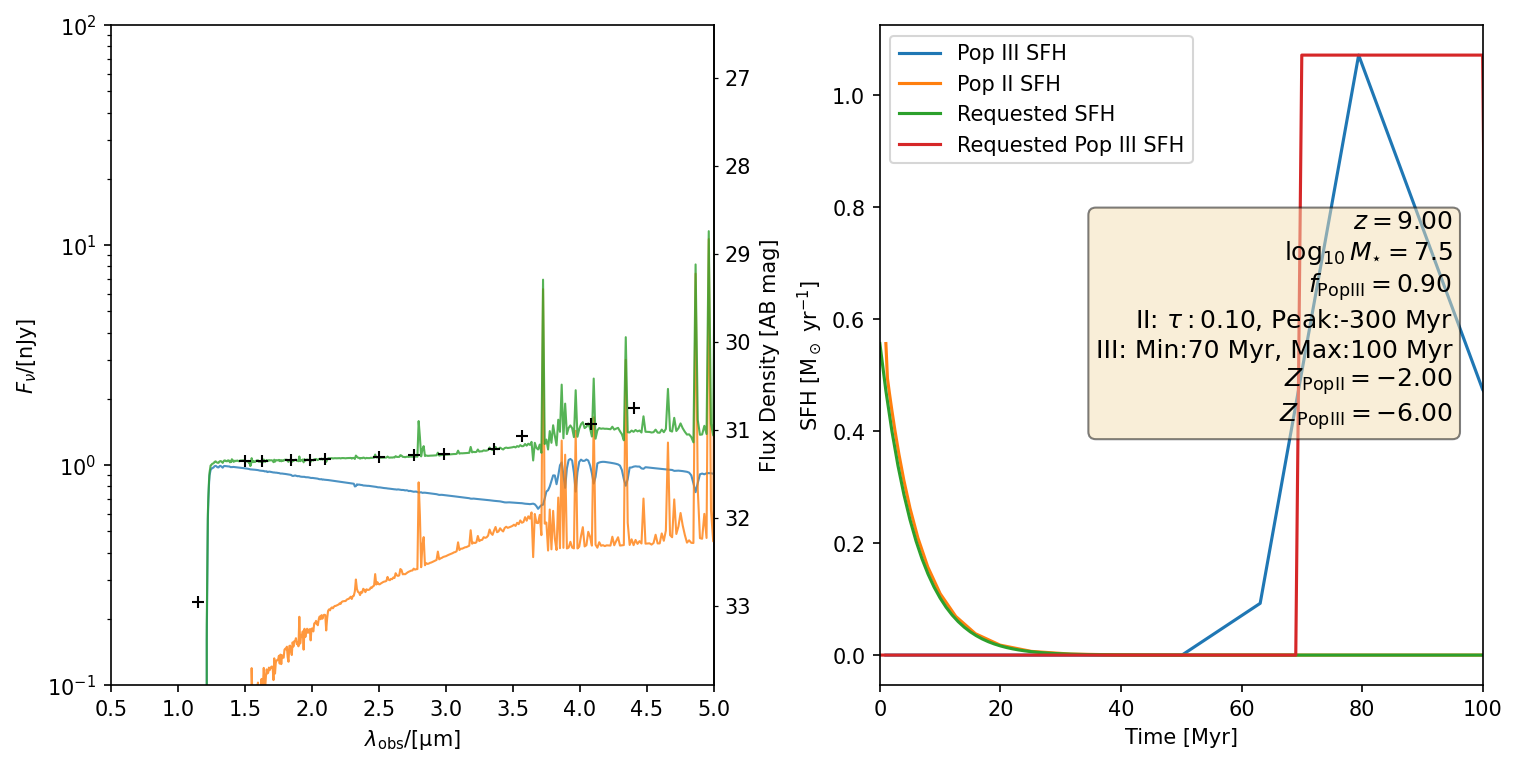

In [ ]:
log_mass =  7.5
redshift = 9
igm = Inoue14

frac = 0.9 # fraction of mass in pop III stars

mass = 10**log_mass * Msun
popII_mass = mass * (1 - frac)
popIII_mass = mass * frac

tau = 0.1
peak_age = -300 * Myr

min_popIII_age = 70 * Myr
max_popIII_age = 100 * Myr

metal_dist = ZDist.DeltaConstant(log10metallicity=-2.0)

sfh = SFH.LogNormal(
    tau=tau,
    peak_age=peak_age, 
    max_age=(cosmo.age(redshift).to(u.Myr).value - cosmo.age(max_redshift).to(u.Myr).value)*Myr,
)

emission_model = TotalEmission(
    grid=grid,
    #tau_v=0.1,
    dust_curve=dust_curve,
    fesc=0,
    fesc_ly_alpha=0,
)

# Create the Pop II stars
stars = Stars(
    grid.log10age,
    grid.metallicity,
    sf_hist=sfh,
    metal_dist=metal_dist,
    initial_mass=popII_mass,
    tau_v=1,
)

galaxy = Galaxy(
    stars=stars,
    redshift=redshift,
)



sed = galaxy.stars.get_spectra(emission_model)
galaxy.get_observed_spectra(cosmo=cosmo, igm=igm)

# Create the Pop III stars if specified

popIII_sps_grid = grid # placeholder for the popIII sps grid
popIII_sfh = SFH.Constant(
    min_age= min_popIII_age,
    max_age = max_popIII_age,
)

popIII_metal_dist = ZDist.DeltaConstant(log10metallicity=-6.0)

popIII_emission_model = IntrinsicEmission(
    grid=popIII_sps_grid,
    fesc=1,
    fesc_ly_alpha=0,
)

popIII_stars = Stars(
    popIII_sps_grid.log10age,
    popIII_sps_grid.metallicity,
    sf_hist=popIII_sfh,
    metal_dist=popIII_metal_dist,
    initial_mass=popIII_mass,
    tau_v=0,
)

popIII_galaxy = Galaxy(
    stars=popIII_stars,
    redshift=redshift, #hmmm 
)

popIII_sed = popIII_galaxy.stars.get_spectra(popIII_emission_model)
popIII_galaxy.get_observed_spectra(cosmo=cosmo, igm=igm)

combined_galaxy_sed = galaxy.stars.spectra['total'] + popIII_galaxy.stars.spectra['intrinsic']
phot = combined_galaxy_sed.get_photo_fnu(filters=filterset)


fig, ax = plt.subplots(1, 2, figsize=(10, 5), layout='constrained') 


plot_spectra(
    {
        'Combined': galaxy.stars.spectra['total'] + popIII_galaxy.stars.spectra['intrinsic'],
        'Pop II': galaxy.stars.spectra['total'], 
        'Pop III': popIII_galaxy.stars.spectra['intrinsic'],
    },
    show=False,
    xlimits=(5000, 50_000) * Angstrom,
    ylimits = (0.1, 100) * nJy,
    fig=fig,
    ax = ax[0],
    x_units=um,
    quantity_to_plot='fnu',
    draw_legend=False,
)

ax[0].set_yscale('log')

# Custom xtick label formatter which divides by 1e4

def custom_xticks(x, pos):
    if x == 0:
        return '0'
    else:
        return f'{x/1e4:.1f}'

ax[0].xaxis.set_major_formatter(FuncFormatter(custom_xticks))



popII_sfh = galaxy.stars.get_sfh()
popIII_sfh = popIII_galaxy.stars.get_sfh() # This is just in Msun every gap Convert to Msun yr^-1

popIII_sfh = popIII_sfh / np.diff(10**(popIII_sps_grid.log10age), prepend=0) / yr
popII_sfh = popII_sfh / np.diff(10**(grid.log10age), prepend=0) / yr

ax[1].plot(10**(popIII_sps_grid.log10age-6), popIII_sfh, label='Pop III SFH')
ax[1].plot(10**(grid.log10age-6), popII_sfh, label='Pop II SFH')

# theoretical SFH

t, sfh = galaxy.stars.sf_hist_func.calculate_sfh()

ax[1].plot(t/1e6, sfh/np.max(sfh) * np.max(popII_sfh), label='Requested SFH')
           

t, sfh = popIII_galaxy.stars.sf_hist_func.calculate_sfh()
ax[1].plot(t/1e6, sfh/np.max(sfh) * np.max(popIII_sfh), label='Requested Pop III SFH')

# Make a text box with total mass, mass fraction, metallicity, redshift etc

textstr = '\n'.join((
    r'$z = %.2f$' % (redshift, ),
    r'$\log_{10} M_{\star} = %.1f$' % (np.log10(mass.to(kg)/Msun.to(kg).value), ),
    r'$f_{\rm Pop III} = %.2f$' % (frac, ),
    rf'II: $\tau:{tau:.2f}$, Peak:{peak_age:.0f}',
    rf'III: Min:{min_popIII_age:.0f}, Max:{max_popIII_age:.0f}',
    r'$Z_{\rm Pop II} = %.2f$' % (metal_dist.log10metallicity_, ),
    r'$Z_{\rm Pop III} = %.2f$' % (popIII_metal_dist.log10metallicity_, ),
))

# these are matplotlib.patch.Patch properties
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
# place a text box in upper left in axes coords
ax[1].text(0.95, 0.72, textstr, transform=ax[1].transAxes, fontsize=12, horizontalalignment='right',
        verticalalignment='top', bbox=props)

# add a secondary axis with AB magnitudes

# 31.4

def ab_to_jy(f):
    return 1e9 * 10**(f/(-2.5) -8.9)  

def jy_to_ab(f):
    f = f/1e9
    return -2.5 * np.log10(f) + 8.9

secax = ax[0].secondary_yaxis('right', functions=(jy_to_ab, ab_to_jy))
# set scalar formatter


secax.yaxis.set_major_formatter(ScalarFormatter())
secax.yaxis.set_minor_formatter(ScalarFormatter())
secax.set_ylabel('Flux Density [AB mag]')

ax[1].set_xlabel('Time [Myr]')
ax[1].set_ylabel('SFH [M$_\odot$ yr$^{-1}$]')
#ax[1].set_yscale('log')
ax[1].legend()
ax[1].set_xlim(0, 100)




ax[0].plot(phot.filters.pivot_lams, phot.photo_fnu, '+', color='k', label='Photometry')